In [1]:
!pip3 install patchify segmentation_models
import os
# setting the environment variable "SM_FRAMEWORK" to "tf.keras" to import "segmentation_models" module.
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import segmentation_models as sm
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [2]:
sm.set_framework('tf.keras')

### Loading Image Dataset
* Use of sorted() function is required as the images which from the mounted drive are imported in a random order, which leads to an async between X and Y datasets.

In [3]:
def dataset_load(dir):
  image_dataset = []
  for images in sorted(os.listdir(dir)):
    image = cv2.imread(dir+'/'+images,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128,128))
    image = Image.fromarray(image)
    image = np.array(image)
    image_dataset.append(image)
  return image_dataset

In [5]:
image_dataset = dataset_load("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/dataset/semantic_drone_dataset/original_images")

In [6]:
mask_dataset = dataset_load("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/RGB_color_image_masks/RGB_color_image_masks")

In [43]:
print(image_dataset.shape, mask_dataset.shape)
inside = os.listdir("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/RGB_color_image_masks/RGB_color_image_masks")
for i in range(20):
    print(inside[i])

(400, 128, 128, 3) (400, 128, 128, 3)
005.png
004.png
001.png
002.png
000.png
003.png
006.png
008.png
121.png
043.png
062.png
023.png
014.png
016.png
073.png
026.png
089.png
059.png
045.png
070.png


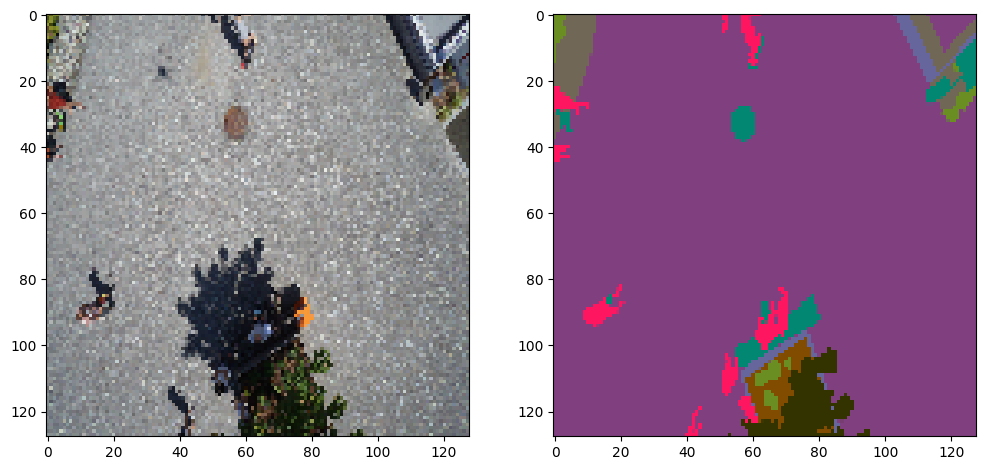

In [20]:
# Checking if the training data is imported properly.
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [21]:
mask_labels = pd.read_csv("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/class_dict_seg.csv")
mask_labels


,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [26]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

labels = np.array(labels)
print(labels.shape, labels.size, type(labels))
labels = np.expand_dims(labels, axis=3) # adding channel dimensionality
print(labels.shape, labels.size)


(400, 128, 128) 6553600
(400, 128, 128, 1) 6553600


Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


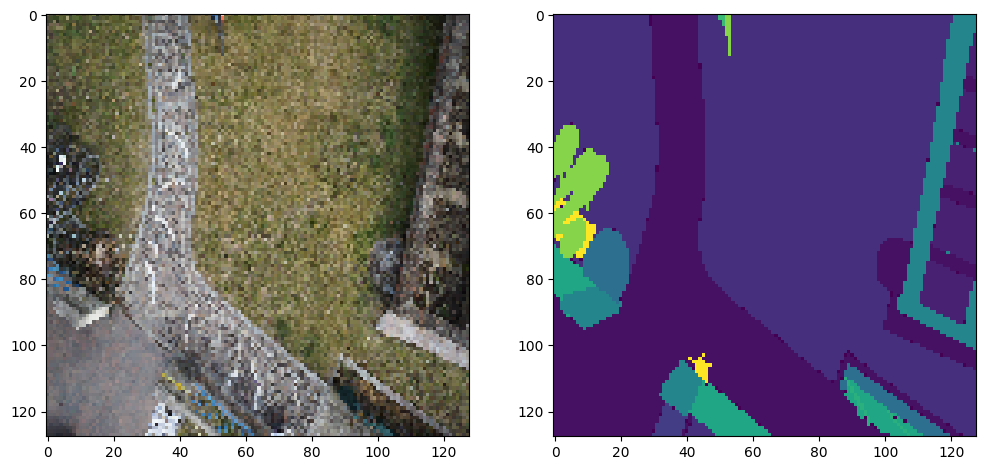

In [24]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [27]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the l
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

### Setting the Backbone and Preprocessing

```BACKBONE = 'resnet34' ```
* This line specifies that 'resnet34', a variant of the ResNet model with 34 layers, will be used as the backbone for the U-Net model. In neural networks, a "backbone" refers to a pre-trained network that is used as the base for another task, providing learned features from a large and diverse dataset (like ImageNet).

``` preprocess_input = sm.get_preprocessing(BACKBONE) ```
* This line retrieves the preprocessing function specific to the 'resnet34' model. Different models often require different kinds of input preprocessing (like normalization, scaling, etc.). sm likely refers to a library or module that contains these functions (possibly segmentation_models if you are using that library).

In [34]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

### **Preprocessing the data**
* Here, we apply the preprocessing function to the training and testing data.
* This ensires that the input data us in the correct format and range expected by the 'resnet34' backbone. This typically involves normalizing the image data to match the distribution with which the model was originally trained.

In [35]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

### **Defining the U-Net Model with ResNet Backbone**
* This function creates a U-Net architecture.U-Net is a popular architecture in image segmentation tasks, particularly known for its effectiveness in medical image segmentation.
* It typically consists of an encoder (downsampling path) and a decoder (upsampling path) with skip connections.
* The BACKBONE parameter specifies that the encoder part of the U-Net should use the 'resnet34' model.
``` encoder_weights='imagenet' ```
* This indicates that the ResNet backbone should be initialized with weights pre-trained on ImageNet, a large dataset of general images. Using pre-trained weights helps in leveraging the features learned by the model on ImageNet, which can improve performance especially when you have limited training data

```classes=n_classes```
* This specifies the number of classes for the segmentation task.

``` activation='softmax' ```
* This is used in the final layer. The softmax activation function is appropriate for multi-class segmentation tasks as it converts the output to a probability distributions over the classes.

In [36]:
#define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [31]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [32]:


model_resnet_backbone.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [33]:


# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))



Epoch 1/100
20/20 [==============================] - 31s 202ms/step - loss: 2.3102 - accuracy: 0.3873 - val_loss: 71.8005 - val_accuracy: 0.3789
Epoch 2/100
20/20 [==============================] - 2s 111ms/step - loss: 1.6161 - accuracy: 0.5746 - val_loss: 2656.8855 - val_accuracy: 0.3789
Epoch 3/100
20/20 [==============================] - 2s 117ms/step - loss: 1.4619 - accuracy: 0.6007 - val_loss: 2966.5337 - val_accuracy: 0.3802
Epoch 4/100
20/20 [==============================] - 2s 114ms/step - loss: 1.2460 - accuracy: 0.6557 - val_loss: 2.8615 - val_accuracy: 0.3601
Epoch 5/100
20/20 [==============================] - 2s 112ms/step - loss: 1.2276 - accuracy: 0.6527 - val_loss: 7.9620 - val_accuracy: 0.4779
Epoch 6/100
20/20 [==============================] - 2s 119ms/step - loss: 1.1123 - accuracy: 0.6774 - val_loss: 1.7006 - val_accuracy: 0.5261
Epoch 7/100
20/20 [==============================] - 2s 121ms/step - loss: 1.0637 - accuracy: 0.6892 - val_loss: 19.3238 - val_accurac

### **Results**

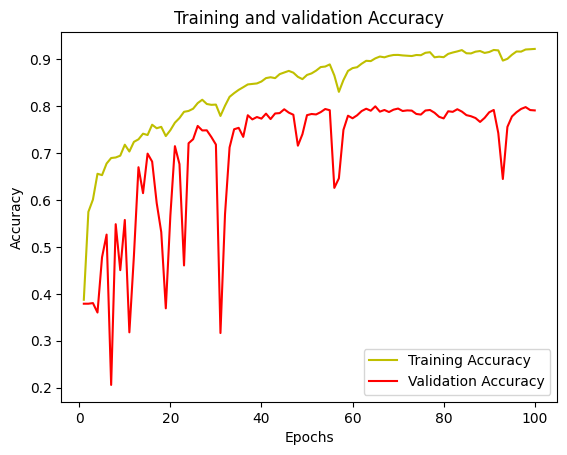

In [37]:


# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
model_resnet_backbone.save('/content/drive/MyDrive/aerial_semantic_segmentation/models/resnet_backbone.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model = load_model('/content/drive/MyDrive/aerial_semantic_segmentation/models/resnet_backbone.hdf5')

In [39]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 [==============================] - 3s 32ms/step


In [40]:
rand_image_number = random.randint(0, len(X_test))
rand_image = X_test[rand_image_number]
ground_truth = y_test_argmax[rand_image_number]
rand_image_input = np.expand_dims(rand_image, 0)
prediction = model.predict(rand_image_input)
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 1s 1s/step


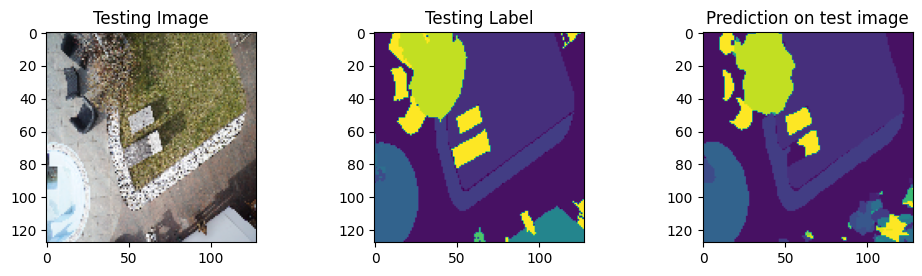

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(rand_image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()